<a href="https://colab.research.google.com/github/pierredumontel/Portfolio_management/blob/main/Notebook/Portfolio_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Management 

Group : 
Aymane ACHOUR,
Pierre DUMONTEL,
Ahmed NEKT,
Yann Harold NGUESSAN,
William ROUET,
Ryan YALAOUI

#Installation des packages necessaires. 

In [ ]:
pip uninstall --quiet matplotlib

Proceed (y/n)? y


In [ ]:
pip install --quiet requests

In [ ]:
pip install --quiet imgaug

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
pip install --quiet matplotlib matplotlib==3.1.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
riskfolio-lib 2.0.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
pip install --quiet yfinance 

In [ ]:
!pip install --quiet riskfolio-lib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# Collection des données

In [ ]:
# Telechargement des prix depuis yahoo finance
assets = ['BDORY','STN','MKC',
         'AWK','CNI','AY','CSCO','OC','ESALY','CADNF','BXBLY','IBDRY','VWDRY',
         'VWSYF','CRTSF','SMAWF','TT','AKZOY','IGIFF','HPE','ACXIF','ABB','NVZMY',
         'JCI','AOMFF','ADSK','TCLAF','BNPQY','BMO','BLL','ALIZF','HPQ','CMA','TU','DASTY','ISNPY','SMSMY',
         'INTC', 'ACN','SNYNF', 'VLEEF', 'CRZBY','CGEAF','SLF','XRX','TKPHF','AEM','ADI',
         'ADDDF','PLD','LNVGF','UL','ORKLY','AZN','SHG','SAP','NRDBY','ERIC','GOOG','TECK',
         'KKPNF','WDAY','TSLA','NVO','CDNAF','NVDA','^GSPC']

start_date = '2016-06-08'
end_date = '2021-12-01'
    
def download_data():
   stock_data = {}
   for stock in assets:
       ticker = yf.Ticker(stock)
       stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
  
   return pd.DataFrame(stock_data)
  
stock_data = download_data()

In [ ]:
stock_data = stock_data.drop(stock_data.index[0])
stock_data.head()

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-08,4.020248,24.343321,44.923573,69.490631,56.648708,13.150183,24.369169,46.316219,59.529999,7.008094,16.130243,21.176006,4.432763,66.458641,58.529301,99.933784,46.202766,18.684538,21.213783,9.646941,60.180882,17.211288,45.022392,35.261520,25.388620,58.529999,11.763619,21.401941,54.366089,35.793926,129.025772,11.633403,38.216717,12.739064,15.309435,11.052011,5.229984,27.650126,108.883766,70.199905,47.53405,8.071660,45.73283,29.495192,21.785183,35.788715,46.964794,51.685375,126.847336,42.197395,0.448791,39.204929,7.329008,24.538774,34.680000,75.833977,7.882724,7.054576,728.280029,11.674519,2.958812,80.459999,47.104000,50.990795,97.146683,11.356851,2119.120117
2016-06-09,3.974216,24.288349,45.519276,70.179085,56.172901,13.040532,24.369169,46.731579,59.299999,7.125648,15.783809,21.160604,4.380611,66.030243,58.529301,97.570641,46.097507,18.444582,20.971506,9.746652,60.180882,16.946747,43.796276,35.464451,25.388620,57.790001,11.763619,21.046318,54.217590,35.755722,125.137253,11.608241,37.455864,12.664106,15.096669,10.964585,5.120323,27.693485,108.993271,69.588745,47.53405,7.770551,45.73283,29.095259,21.529888,35.257782,47.438248,51.488579,127.780457,42.999264,0.448791,38.929253,7.217237,23.975801,34.320000,75.108391,7.715515,6.990360,728.580017,11.268036,2.958812,79.889999,45.872002,50.714344,97.146683,11.651956,2115.479980
2016-06-10,3.728705,23.656178,45.387409,70.206284,55.221283,12.499616,24.277180,45.596279,57.970001,7.125648,15.538770,20.429071,4.192499,63.143173,57.185066,94.616714,45.255424,17.796703,20.707848,9.532276,60.180882,16.577993,42.588745,35.302105,25.388620,56.180000,10.308728,20.108770,53.722595,35.182720,119.237167,11.323069,36.513054,12.545748,14.659424,10.396320,5.103452,27.780186,107.925583,66.677177,47.53405,7.333457,45.73283,28.495356,21.125668,35.257782,46.964794,50.951866,127.590034,43.042377,0.441552,37.793125,7.001677,23.156193,33.619999,72.968803,7.373135,6.788538,719.409973,10.776474,2.958812,77.629997,43.757999,49.367783,94.551895,11.361764,2096.070068
2016-06-13,3.698016,23.665339,45.000881,70.351227,54.596210,12.426521,24.118280,44.876350,57.000000,7.125648,15.428929,20.113356,4.116136,62.137344,57.185066,94.616714,44.595776,17.436768,20.308796,9.273029,60.180882,16.249317,42.458702,35.147869,25.388620,55.889999,10.090884,19.502600,53.161606,34.390057,116.972176,11.030170,36.114101,12.368214,14.583296,9.762487,5.010662,27.892902,106.839676,66.329155,47.53405,7.100341,45.73283,28.253721,20.976748,35.257782,47.744595,50.871357,125.647614,43.094116,0.463268,37.091396,6.889906,22.849871,33.380001,71.433891,7.253699,6.733497,718.359985,10.936784,2.958812,78.889999,43.574001,48.797062,92.921379,11.506863,2079.060059
2016-06-14,3.588204,23.198076,45.191860,70.677345,54.456272,12.492306,24.218636,44.996326,56.220001,7.125648,15.378227,19.612833,4.028599,60.228146,57.185066,91.117432,44.672966,17.052843,20.308796,9.128450,60.180882,16.177170,41.585567,35.147869,22.705351,55.709999,10.090884,19.187389,52.278885,34.347084,113.764740,11.047103,35.324490,12.510242,14.425185,9.420072,5.002227,27.866892,107.761330,63.578880,47.53405,6.954643,45.73283,27.970440,20.700178,35.257782,46.342800,51.050262,122.895866,42.550900,0.448791,36.439785,6.770151,22.568386,32.200001,70.801331,7.150188,6.678454,718.270020,10.443535,2.958812,80.849998,42.992001,46.478489,92.921379,11.528993,2075.320068


# Traitement des données <br/> <br/> 
- Calcul des rendements 
- Partition des données en ensemble d'apprentissage et de validation

In [ ]:
# Obtention des rendements à partir des prix
returns = stock_data.pct_change()
returns = returns.drop(returns.index[:2])
returns.head()

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-10,-0.061776,-0.026028,-0.002897,0.000388,-0.016941,-0.041480,-0.003775,-0.024294,-0.022428,0.000000,-0.015525,-0.034571,-0.042942,-0.043723,-0.022967,-0.030275,-0.018267,-0.035126,-0.012572,-0.021995,0.000000,-0.021760,-0.027572,-0.004578,0.000000,-0.027860,-0.123677,-0.044547,-0.009130,-0.016025,-0.047149,-0.024566,-0.025171,-0.009346,-0.028963,-0.051827,-0.003295,0.003131,-0.009796,-0.041840,0.000000,-0.056250,0.0,-0.020619,-0.018775,0.0,-0.009980,-0.010424,-0.001490,0.001003,-0.016129,-0.029184,-0.029867,-0.034185,-0.020396,-0.028487,-0.044376,-0.028871,-0.012586,-0.043624,0.000000,-0.028289,-0.046085,-0.026552,-0.026710,-0.024905,-0.009175
2016-06-13,-0.008230,0.000387,-0.008516,0.002065,-0.011319,-0.005848,-0.006545,-0.015789,-0.016733,0.000000,-0.007069,-0.015454,-0.018214,-0.015929,0.000000,0.000000,-0.014576,-0.020225,-0.019271,-0.027197,0.000000,-0.019826,-0.003053,-0.004369,0.000000,-0.005162,-0.021132,-0.030145,-0.010442,-0.022530,-0.018996,-0.025867,-0.010926,-0.014151,-0.005193,-0.060967,-0.018182,0.004057,-0.010062,-0.005220,0.000000,-0.031788,0.0,-0.008480,-0.007049,0.0,0.016604,-0.001580,-0.015224,0.001202,0.049180,-0.018568,-0.015963,-0.013229,-0.007139,-0.021035,-0.016199,-0.008108,-0.001460,0.014876,0.000000,0.016231,-0.004205,-0.011561,-0.017245,0.012771,-0.008115
2016-06-14,-0.029695,-0.019745,0.004244,0.004636,-0.002563,0.005294,0.004161,0.002673,-0.013684,0.000000,-0.003286,-0.024885,-0.021267,-0.030725,0.000000,-0.036984,0.001731,-0.022018,0.000000,-0.015591,0.000000,-0.004440,-0.020564,0.000000,-0.105688,-0.003221,0.000000,-0.016162,-0.016604,-0.001250,-0.027421,0.001535,-0.021864,0.011483,-0.010842,-0.035075,-0.001683,-0.000933,0.008627,-0.041464,0.000000,-0.020520,0.0,-0.010026,-0.013185,0.0,-0.029360,0.003517,-0.021901,-0.012605,-0.031250,-0.017568,-0.017381,-0.012319,-0.035351,-0.008855,-0.014270,-0.008174,-0.000125,-0.045100,0.000000,0.024845,-0.013357,-0.047515,0.000000,0.001923,-0.001799
2016-06-15,0.000000,0.000395,0.003119,-0.002692,-0.004797,0.004096,-0.010704,-0.005743,0.008360,0.000000,0.002747,0.003141,-0.003237,0.002783,0.000000,0.017456,0.010368,0.007036,0.000000,0.026761,-0.021725,0.007433,0.014295,-0.005774,0.000000,0.016155,0.043176,0.003791,-0.001894,0.001112,-0.003411,-0.003832,0.006353,0.000000,0.015697,0.023975,0.033727,-0.016490,-0.005420,0.028171,0.000000,-0.002793,0.0,-0.011915,0.018499,0.0,0.026843,-0.003504,0.005733,0.010740,0.000000,0.003668,0.011792,0.004035,-0.000621,-0.003679,0.011136,0.056319,0.000905,0.046322,-0.081683,-0.007668,0.012747,-0.005180,0.000000,0.010239,-0.001841
2016-06-16,0.008621,0.000790,0.007824,0.011181,-0.001721,0.010490,0.007679,0.025170,-0.030164,-0.073604,-0.007671,0.013307,0.001856,-0.006322,0.000000,0.000980,0.003576,0.002328,0.000000,-0.007447,0.000000,-0.000984,-0.007487,0.004414,-0.024065,0.002826,0.000000,0.000000,-0.005376,-0.002083,0.015856,-0.001538,-0.019640,0.011353,-0.010392,0.005287,-0.052202,0.002531,0.007237,-0.015582,-0.058779,-0.011204,0.0,0.007537,-0.021191,0.0,-0.014631,0.000528,-0.000847,0.009022,-0.016129,0.013933,-0.018648,0.009499,-0.000311,0.004879,-0.015419,-0.002601,-0.011907,-0.003472,0.000000,-0.011592,0.001056,-0.005593,0.000000,0.004012,0.003133


In [ ]:
train_size_stock = int(len(stock_data) * 0.46032)
train_stock, test_stock = stock_data[0:train_size_stock], stock_data[train_size_stock:len(stock_data)]
train_size_rets = int(len(returns) * 0.46032)
train_rets, test_rets = returns[0:train_size_rets], returns[train_size_rets:len(returns)]
print('Observations totales: %d' % (len(stock_data)))
print('Observations dans le trainset : %d' % (len(train_rets)))
print('Observations dans le testset: %d' % (len(test_rets)))

Observations totales: 1381
Observations dans le trainset : 634
Observations dans le testset: 745


#Calcul des poids des actifs <br/> <br/> 
Pour calculer les poids accordés à chaque actif, nous allons nous servir de la librairie riskfolio. Elle permet de calculer les poids via différents moyens : 
- Minimisation du risque 
- Maximisation des rendements 
- etc. 
https://riskfolio-lib.readthedocs.io/en/latest/index.html

Dans la cellule de code ci-dessous, nous allons calculer le poids optimal de notre portefeuille(sur le trainset) en instaurant une à la fois une contrainte sur le nombre minimal d'actifs non significatif (actif avec un poids très négligeable 0.0x%) et sur le nombre d'actif total dans le portefeuille. Pour obtenir les poids nous allons maximiser le ratio de sharpe<br/>  <br/> 

mesure de risque utilisée : variance  <br/>
fonction objective: ratio de sharpe  <br/>

In [ ]:
import riskfolio as rp
port = rp.Portfolio(returns=train_rets)
method_mu='hist' 
method_cov='hist' 
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)


model='Classic' 
rm = 'MV' 
obj = 'Sharpe' #Fonction objective
hist = True 
rf = 0 
l = 0 

port.card = None 

w_sr= {}
data = {}
var = {}
std = {}
ret = {}
SR = {}
stats_sr = {}


for nb_stocks, port.nea in zip(range(27,34),range(27,34)):
  w_sr[port.nea] = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
  data[nb_stocks] = pd.DataFrame(w_sr[port.nea])
  data[nb_stocks] = data[nb_stocks].T
  data[nb_stocks] = data[nb_stocks].reset_index()
  data[nb_stocks] = data[nb_stocks].drop(columns='index')
  data[nb_stocks] = data[nb_stocks].T
  var[nb_stocks] = data[nb_stocks] * (train_rets.cov() @ data[nb_stocks]) * 252
  var[nb_stocks] = var[nb_stocks].sum().to_frame().T #variance
  std[nb_stocks] = np.sqrt(var[nb_stocks])  
  ret[nb_stocks] = train_rets.mean().to_frame().T @ data[nb_stocks] * 252 
  SR[nb_stocks] = (ret[nb_stocks] - 0.0176)/std[nb_stocks] #Sharpe ratio
  stats_sr[nb_stocks] = pd.concat([ret[nb_stocks], std[nb_stocks], var[nb_stocks], SR[nb_stocks]], axis=0)
  stats_sr[nb_stocks].index = ['Return', 'Std. Dev.', 'Variance', 'Sharpe Ratio']
 

#Résulats pour différents nombres d'actifs dans le portefeuille (27,28...33)
stats = pd.concat([stats_sr[27],stats_sr[28],stats_sr[29],stats_sr[30],stats_sr[31],stats_sr[32],stats_sr[33]],axis=1)
stats = stats.set_axis(['Max Sharpe 27','Max Sharpe 28', 'Max Sharpe 29', 'Max Sharpe 30','Max Sharpe 31', 'Max Sharpe 32','Max Sharpe 33'], axis=1)
stats

,Max Sharpe 27,Max Sharpe 28,Max Sharpe 29,Max Sharpe 30,Max Sharpe 31,Max Sharpe 32,Max Sharpe 33
Return,0.207825,0.207109,0.206385,0.205634,0.204751,0.203754,0.202749
Std. Dev.,0.098995,0.099494,0.100000,0.100506,0.100956,0.101355,0.101755
Variance,0.009800,0.009899,0.010000,0.010101,0.010192,0.010273,0.010354
Sharpe Ratio,1.921558,1.904723,1.887838,1.870876,1.853787,1.836660,1.819548


In [ ]:
#Création d'une fonction pour calculer le poids optimal
#On restreint les poids très négligeable à zéro. Seuil de négligeabilité  0.1% : 

def calcule_portefeuille_optimal (return_data) : 
  port = rp.Portfolio(returns=return_data) 
  port.nea = 30 #On veut au minimum 30 actifs dans le portefeuille
  method_mu='hist' 
  method_cov='hist' 
  port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
  model='Classic' 
  rm = 'MV' 
  obj = 'Sharpe' 
  hist = True 
  rf = 0 
  l = 0 
  port.card = None  # First we need to delete the cardinality constraint


  opti_portfolio = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)*100 #Caclule des poids en pourcentage
  opti_portfolio = opti_portfolio.reset_index().rename(columns={"index": "Actif", "weights": "Poids"})
  
  #Contrainte pour mettre à zéro les poids très négligeable : poids < 0.1%
  opti_portfolio.loc[(opti_portfolio.Poids < 0.1 ), 'Poids'] = 0 
  
  return opti_portfolio

In [ ]:
#Exemple
poids = data[30].applymap(lambda x: "{0:.4f}".format(x*100))
poids = poids.T
poids

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
0,3.8763,0.0000,5.3217,4.5365,1.3887,2.1888,2.4941,0.0000,3.2015,3.7180,0.0000,0.7588,0.0000,0.1754,5.7322,0.0000,1.7779,0.6574,0.6766,0.0000,4.2276,0.0000,0.0000,0.0000,7.0641,2.1824,2.0487,0.0000,0.0358,1.0037,1.8281,1.6351,2.2081,2.3810,2.1023,0.0000,2.0193,1.1289,0.9101,2.0999,0.0000,0.0000,2.7101,0.0000,0.0000,0.0000,0.0000,1.1164,4.2600,2.7393,2.7288,1.4124,0.0000,3.1986,0.0000,0.0000,0.0000,0.1789,0.0001,1.4892,1.4887,1.9067,1.9076,0.0000,1.1808,4.3032,0.0001


In [ ]:
#Performance du portefeuille plus haut sur le testset : Exemple
var_t = data[30] * (test_rets.cov() @ data[30]) * 252
var_t = var_t.sum().to_frame().T
std_t = np.sqrt(var_t) 
ret_t = test_rets.mean().to_frame().T @ data[30] * 252
SR_t = (ret_t - 0.0176)/std_t

stats_sr_t = pd.concat([ret_t, std_t, SR_t], axis=0)
stats_sr_tt = stats_sr_t
stats_sr_t.index = ['Rendement', 'Volatilité', 'Sharpe ratio']
stats_sr_t = stats_sr_t.T
stats_sr_t[["Rendement","Volatilité"]] = stats_sr_t[["Rendement","Volatilité"]].applymap(lambda x: "{0:.1f}%".format(x*100))
stats_sr_t[["Sharpe ratio"]] = stats_sr_t[["Sharpe ratio"]].applymap(lambda x: "{0:.2f}".format(x))
display(stats_sr_t)

,Rendement,Volatilité,Sharpe ratio
0,23.0%,18.2%,1.17


# Frontière efficiente

In [ ]:
port.nea =30
points = 50
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
display(frontier.T.head())

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
0,2.908786e-10,8.337457e-03,0.040252,0.056426,0.013759,0.021444,0.007153,1.145333e-02,0.013878,0.030329,2.101688e-02,0.002363,9.094562e-10,0.004765,0.049811,8.549790e-03,0.000024,0.004705,0.037983,1.963805e-09,0.040401,6.780839e-04,4.330707e-09,3.170784e-03,0.052879,2.502405e-10,0.028461,4.020466e-10,0.027984,0.017456,0.007293,7.112495e-10,0.009762,0.043498,0.003306,2.077482e-10,0.002171,4.548440e-09,0.013615,0.041954,1.736504e-02,3.703991e-10,0.063045,0.018329,4.028841e-09,0.038716,0.021037,0.001359,0.013216,0.020780,0.018699,0.012209,0.014272,0.016923,7.762508e-03,1.536005e-09,3.293234e-09,0.001721,4.681362e-09,1.796184e-10,0.036516,3.794809e-10,0.001283,9.720665e-03,0.038573,4.012967e-10,0.023595
1,1.868204e-08,7.834275e-04,0.047934,0.057228,0.016431,0.023316,0.015181,4.037299e-03,0.019832,0.033495,9.322134e-03,0.004059,4.836455e-10,0.004225,0.055334,3.857494e-03,0.006648,0.006305,0.031462,1.683123e-09,0.042643,6.829265e-10,5.583496e-10,4.798239e-10,0.062682,3.092603e-10,0.028177,1.670197e-10,0.022913,0.016761,0.011616,1.409442e-09,0.016975,0.041955,0.010576,1.015353e-10,0.007018,3.557104e-03,0.013964,0.038981,5.188964e-03,1.596981e-10,0.055949,0.011192,5.828074e-10,0.030172,0.017441,0.007120,0.022080,0.025071,0.021177,0.014568,0.007699,0.023657,3.174741e-03,7.514635e-10,6.180477e-10,0.002033,1.351993e-03,1.734312e-10,0.032596,6.199357e-10,0.006588,8.257126e-04,0.032553,3.420421e-03,0.018873
2,4.036857e-03,1.291380e-10,0.049826,0.056552,0.016928,0.023873,0.017140,1.077727e-03,0.021884,0.034451,5.274025e-03,0.004750,2.350662e-11,0.004078,0.056480,2.274424e-03,0.008866,0.006974,0.028888,8.986223e-11,0.043456,2.425563e-11,2.098132e-11,1.594224e-11,0.065190,2.632124e-11,0.027837,7.631916e-12,0.020454,0.016015,0.013095,1.124529e-09,0.018674,0.040579,0.012927,4.871106e-12,0.009102,4.741023e-03,0.013851,0.037537,1.005620e-03,7.326878e-12,0.052976,0.008696,2.275125e-11,0.026799,0.015868,0.008259,0.025354,0.026310,0.022095,0.015277,0.005180,0.025456,1.332557e-03,3.460072e-11,2.428346e-11,0.002149,1.778296e-03,1.168519e-11,0.031134,8.120462e-11,0.008217,8.262488e-11,0.030382,8.314365e-03,0.016603
3,7.713416e-03,2.008472e-10,0.051176,0.055898,0.017114,0.024189,0.018469,3.706239e-10,0.023480,0.035129,1.705784e-03,0.005213,9.451862e-11,0.003953,0.057411,8.836006e-04,0.010368,0.007297,0.026549,2.992483e-10,0.044096,7.755765e-11,7.028257e-11,5.034298e-11,0.067147,2.478129e-10,0.027384,2.978108e-11,0.018200,0.015389,0.014144,2.152543e-03,0.019739,0.039303,0.014537,1.985766e-11,0.010692,5.497302e-03,0.013512,0.036064,1.736858e-10,2.855748e-11,0.050403,0.006360,7.545951e-11,0.023731,0.014191,0.008878,0.027956,0.027081,0.022764,0.015590,0.003059,0.026811,1.099258e-09,1.279686e-10,8.095895e-11,0.002115,1.703283e-03,6.931042e-11,0.029686,7.982737e-04,0.009488,1.437446e-10,0.028341,1.218988e-02,0.014450
4,1.109808e-02,4.973633e-10,0.052262,0.055278,0.017071,0.024243,0.019463,5.951118e-10,0.024793,0.035610,1.622100e-09,0.005498,3.496969e-10,0.003668,0.058229,1.109911e-08,0.011492,0.007392,0.024311,9.889140e-10,0.044504,2.467771e-10,2.297269e-10,1.582175e-10,0.068836,1.575553e-04,0.026894,1.058001e-10,0.016051,0.014714,0.014912,3.917892e-03,0.020429,0.038035,0.015694,7.262206e-11,0.012023,6.061687e-03,0.013015,0.034624,3.090850e-10,1.012201e-10,0.048103,0.004036,2.443534e-10,0.020825,0.012476,0.009147,0.030167,0.027549,0.023278,0.015627,0.001065,0.027877,1.323419e-09,4.496160e-10,2.630159e-10,0.002026,1.301195e-03,4.014141e-10,0.028295,3.113752e-03,0.010555,3.734493e-10,0.026481,1.543102e-02,0.012372


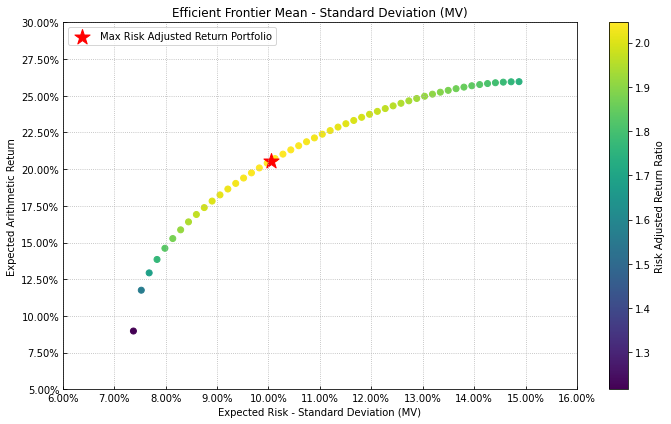

In [ ]:
# Plotting the efficient frontier
import riskfolio.PlotFunctions as plf
label = 'Max Risk Adjusted Return Portfolio' # Title of plot
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
ret = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=ret, rm=rm, rf=rf, alpha=0.05, cmap='viridis',
                       w=data[30], label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

#Strategie de test 1 :  Long/short strategy <br/>


- Etape 1 : traitement des données pour obtenir les signaux à chaque date et pour chaque stocks

In [ ]:
tr_sto = stock_data

In [ ]:
SMA_50 = []
SMA_200 = []
for x in tr_sto:
    SMA_50.append(tr_sto[x].rolling(window = 50, min_periods = 1).mean())
    SMA_200.append(tr_sto[x].rolling(window = 200, min_periods = 1).mean())
SMA_200 = pd.DataFrame(SMA_200).T
SMA_50 = pd.DataFrame(SMA_50).T
SMA_200 = SMA_200.drop(SMA_200.index[0])
SMA_50 = SMA_50.drop(SMA_50.index[0])

SMA_50.head()

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-09,3.997232,24.315835,45.221424,69.834858,56.410805,13.095357,24.369169,46.523899,59.414999,7.066871,15.957026,21.168305,4.406687,66.244442,58.529301,98.752213,46.150137,18.564560,21.092645,9.696796,60.180882,17.079018,44.409334,35.362986,25.388620,58.1600,11.763619,21.224130,54.291840,35.774824,127.081512,11.620822,37.836290,12.701585,15.203052,11.008298,5.175153,27.671805,108.938519,69.894325,47.53405,7.921105,45.73283,29.295225,21.657536,35.523249,47.201521,51.586977,127.313896,42.598330,0.448791,39.067091,7.273122,24.257288,34.500000,75.471184,7.799119,7.022468,728.430023,11.471277,2.958812,80.174999,46.488001,50.852570,97.146683,11.504403,2117.300049
2016-06-10,3.907723,24.095949,45.276752,69.958666,56.014297,12.896777,24.338506,46.214692,58.933333,7.086464,15.817607,20.921894,4.335291,65.210686,58.081223,97.373713,45.851899,18.308608,20.964379,9.641956,60.180882,16.912010,43.802471,35.342692,25.388620,57.5000,11.278656,20.852343,54.102091,35.577456,124.466731,11.521571,37.395212,12.649639,15.021843,10.804305,5.151253,27.707932,108.600873,68.821943,47.53405,7.725223,45.73283,29.028602,21.480246,35.434760,47.122612,51.375273,127.405942,42.746346,0.446378,38.642436,7.182640,23.890256,34.206666,74.637057,7.657125,6.944491,725.423340,11.239676,2.958812,79.326665,45.578000,50.357641,96.281754,11.456857,2110.223389
2016-06-13,3.855296,23.988297,45.207785,70.056807,55.659776,12.779213,24.283450,45.880107,58.450000,7.096260,15.720438,20.719759,4.280502,64.442350,57.857183,96.684464,45.537868,18.090648,20.800483,9.549725,60.180882,16.746336,43.466529,35.293986,25.388620,57.0975,10.981713,20.514907,53.866970,35.280606,122.593092,11.398721,37.074934,12.579283,14.912206,10.543851,5.116105,27.754175,108.160574,68.198746,47.53405,7.569002,45.73283,28.834882,21.354372,35.390515,47.278108,51.249294,126.966360,42.833288,0.450600,38.254676,7.109457,23.630160,34.000000,73.836266,7.556268,6.891743,723.657501,11.163953,2.958812,79.217499,45.077001,49.967496,95.441660,11.469358,2102.432556
2016-06-14,3.801878,23.830252,45.204600,70.180914,55.419075,12.721832,24.270487,45.703351,58.004000,7.102138,15.651996,20.498374,4.230122,63.599509,57.722760,95.571057,45.364888,17.883087,20.702146,9.465470,60.180882,16.632503,43.090337,35.264763,24.851966,56.8200,10.803547,20.249404,53.549353,35.093902,120.827422,11.328397,36.724845,12.565475,14.814802,10.319095,5.093330,27.776718,108.080725,67.274773,47.53405,7.446130,45.73283,28.661993,21.223533,35.363969,47.091046,51.209488,126.152261,42.776810,0.450239,37.891698,7.041596,23.417805,33.640000,73.229279,7.475052,6.849085,722.580005,11.019869,2.958812,79.543999,44.660001,49.269695,94.937604,11.481285,2097.010059
2016-06-15,3.766266,23.726417,45.225972,70.231946,55.215069,12.692105,24.218638,45.542442,57.785000,7.106056,15.613409,20.361051,4.194361,63.065555,57.633144,95.093882,45.326760,17.764709,20.636587,9.450014,59.962982,16.576655,42.938621,35.211459,24.494197,56.7850,10.757385,20.084525,53.321109,34.975798,119.585631,11.274460,36.528855,12.556269,14.787604,10.206899,5.106264,27.715158,107.930157,66.957302,47.53405,7.360978,45.73283,28.491188,21.200131,35.346271,47.173669,51.153133,125.726959,42.815323,0.449997,37.671989,7.009661,23.291414,33.396667,72.781208,7.434179,6.883334,721.970001,11.004441,2.918531,79.658333,44.473334,48.764364,94.601566,11.508911,2092.758382


In [ ]:
SMA_50.tail()

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-23,5.342603,52.019268,81.538179,172.414572,124.538401,36.920827,55.430385,90.601575,72.3862,11.954196,15.3814,44.001707,12.7202,38.3048,81.334951,166.8436,181.360537,37.721562,37.652439,14.567924,176.9650,34.2898,73.3148,73.145911,36.8172,301.686402,15.687436,33.028850,105.936600,91.856023,230.2122,29.236334,83.409895,22.369277,57.2586,16.300724,10.160869,51.828809,346.015504,98.9632,29.3146,7.1914,85.887904,54.248910,19.839545,29.680804,54.013781,175.099942,322.334199,138.375419,1.045044,52.941843,9.4722,60.1166,32.7140,142.008200,12.5172,11.239596,2859.196802,26.856892,3.1198,275.598601,932.942200,105.2708,145.097418,246.207253,4520.676367
2021-11-24,5.340360,52.109273,81.548156,172.222877,124.811801,36.959983,55.397901,90.535814,72.1074,11.935421,15.3554,44.004461,12.6690,38.1474,81.117747,166.7576,181.530195,37.675001,37.687921,14.590152,177.1894,34.2606,73.2984,73.213543,36.8524,301.092002,15.656676,33.063948,106.133748,91.864206,230.1964,29.385120,83.751835,22.380551,57.2556,16.294792,10.182031,51.729222,346.393714,98.9666,29.4006,7.2156,85.661572,54.323983,19.828639,29.566244,53.928971,175.267102,321.574199,138.810689,1.043658,52.894769,9.4820,60.1144,32.6808,141.796400,12.5118,11.218616,2859.801401,26.860088,3.1164,275.759201,940.145599,105.4262,144.742189,248.273599,4525.091562
2021-11-26,5.339916,52.194635,81.544053,172.008042,125.033201,36.991821,55.352662,90.399712,71.8250,11.915016,15.3200,44.017644,12.6250,38.0174,80.920244,166.5660,181.702246,37.603469,37.722817,14.605433,177.4138,34.2122,73.2612,73.261027,36.8648,300.361802,15.627091,33.069302,106.270488,91.903123,230.0164,29.515035,83.979926,22.386682,57.2552,16.270451,10.205148,51.615796,346.640734,98.9700,29.4666,7.2326,85.435241,54.378033,19.799526,29.438018,53.889247,175.362537,320.628399,139.155318,1.041872,52.863818,9.4896,60.1140,32.6252,141.512800,12.4912,11.191236,2859.174404,26.864282,3.1100,275.888800,946.644200,105.5420,144.335644,250.125573,4527.508965
2021-11-29,5.341041,52.301897,81.565662,171.926346,125.234400,37.036344,55.338574,90.314061,71.5126,11.894773,15.2822,44.036925,12.5866,37.9102,80.722740,166.3104,181.884265,37.546828,37.753464,14.626470,177.7136,34.1942,73.2172,73.341517,36.8420,299.821802,15.601574,33.082753,106.427631,91.952020,229.8888,29.678918,84.203059,22.398549,57.2880,16.249475,10.224439,51.538090,347.267366,98.9680,29.5336,7.2460,85.208909,54.448519,19.768632,29.304992,53.838599,175.595245,319.814199,139.616883,1.040286,52.849957,9.4966,60.1134,32.5852,141.304999,12.4748,11.173988,2861.034604,26.902027,3.1044,276.150400,954.194200,105.6796,143.991499,252.420492,4531.954561
2021-11-30,5.349661,52.400938,81.576263,171.725537,125.486600,37.092022,55.325154,90.224108,71.1990,11.871292,15.2474,44.061716,12.5496,37.7972,80.486236,166.2134,181.955637,37.495710,37.766395,14.647705,177.9598,34.1916,73.1904,73.387221,36.7888,299.233602,15.576180,33.122337,106.571962,91.969933,229.9504,29.838629,84.412507,22.410020,57.3212,16.231992,10.238730,51.469808,347.787888,98.9660,29.5952,7.2676,84.919777,54.528181,19.724658,29.183818,53.781523,175.809823,318.902799,140.048965,1.038506,52.792349,9.5040,60.0400,32.5328,141.090399,12.4592,11.156677,2862.408604,26.952354,3.0994,276.291200,962.486001,105.8230,143.761208,254.732809,4536.139961


In [ ]:
SMA_200.tail()

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-23,5.568295,46.300821,85.242250,162.144592,114.06820,36.427588,52.676704,93.208642,76.82915,12.055014,16.209374,48.349741,12.817812,78.733141,86.507994,164.38870,178.937402,39.140483,34.111792,14.789502,162.891941,33.768668,71.944900,66.991073,45.928486,294.675500,17.533917,31.048886,97.392483,87.797176,242.167937,29.638374,73.353408,21.454260,50.568798,15.635271,11.097419,55.828308,304.670055,99.946798,31.713682,6.83395,91.536100,51.574748,22.402211,32.416380,59.786588,163.277589,344.007080,122.116894,1.120859,55.418244,9.633560,55.777560,33.59105,138.506069,11.186944,12.291816,2542.154647,23.308858,3.216932,252.61245,739.671049,87.728804,149.780027,189.042782,4282.164392
2021-11-24,5.565902,46.390017,85.221174,162.196553,114.19020,36.422070,52.722800,93.242626,76.76485,12.048978,16.203782,48.319816,12.805518,77.897677,86.443969,164.43260,179.179708,39.156734,34.169242,14.795611,163.061092,33.802655,72.002399,67.127876,45.858474,294.451451,17.526778,31.083194,97.572658,87.818214,242.170268,29.682126,73.498297,21.467584,50.631527,15.643609,11.104092,55.788505,305.207162,99.977800,31.671373,6.83880,91.514660,51.615727,22.389546,32.383929,59.686737,163.432871,343.835232,122.359378,1.119666,55.417120,9.633728,55.816096,33.60215,138.536493,11.205140,12.277387,2546.349498,23.345756,3.216746,252.63140,741.226949,87.925014,149.784447,189.938713,4286.122292
2021-11-26,5.563920,46.475351,85.204875,162.232914,114.28365,36.417054,52.762916,93.254283,76.70215,12.039987,16.196717,48.288657,12.791243,77.012197,86.384917,164.45785,179.403349,39.168287,34.225552,14.798472,163.213413,33.831352,72.052180,67.253179,45.782622,294.221251,17.520406,31.107934,97.739091,87.851487,242.116818,29.720487,73.624627,21.480091,50.700400,15.646940,11.112219,55.734976,305.690497,100.017953,31.621766,6.84390,91.493221,51.647670,22.371944,32.348995,59.597443,163.538494,343.501732,122.577627,1.118324,55.417464,9.634395,55.855248,33.60475,138.537997,11.220788,12.261357,2550.150649,23.377514,3.215137,252.63920,742.578249,88.103390,149.772836,190.751798,4289.513494
2021-11-29,5.562078,46.561682,85.196930,162.299855,114.37240,36.420643,52.809863,93.264940,76.63920,12.031062,16.189934,48.257210,12.777337,76.127303,86.325866,164.46400,179.620115,39.177732,34.286918,14.801307,163.396854,33.861536,72.096330,67.379769,45.706769,294.001300,17.513145,31.130124,97.901250,87.879604,242.068045,29.765016,73.747301,21.494248,50.771574,15.649301,11.115832,55.681908,306.242190,100.048460,31.570086,6.84845,91.437108,51.681053,22.353275,32.316443,59.523577,163.660281,343.184690,122.813250,1.116889,55.415782,9.634771,55.881364,33.60740,138.553654,11.237490,12.245934,2554.241498,23.412167,3.213007,252.64035,744.182599,88.273100,149.776826,191.672984,4293.115693
2021-11-30,5.560888,46.644057,85.196544,162.343639,114.45460,36.424210,52.856033,93.271892,76.57230,12.019360,16.182637,48.231107,12.759334,75.192743,86.257064,164.48620,179.803853,39.183587,34.334179,14.803238,163.535711,33.889700,72.148083,67.491289,45.630266,293.731150,17.504201,31.148083,98.043788,87.899439,242.025791,29.807925,73.838785,21.507453,50.844494,15.650203,11.114511,55.621605,306.753967,100.071260,31.510181,6.85155,91.365295,51.711703,22.329747,32.284436,59.460778,163.768800,342.835973,123.041615,1.115361,55.401222,9.635269,55.907873,33.60520,138.552616,11.251562,12.230384,2557.877199,23.441950,3.211348,252.63715,745.925299,88.439236,149.759165,192.540741,4296.287743


In [ ]:
df_signal = []
for x in tr_sto:
    df_signal.append(tr_sto[x].rolling(window = 50, min_periods = 1).mean())
df_signal = pd.DataFrame(df_signal)
df_signal = df_signal.T
df_signal[df_signal > 0] = 0
df_signal = df_signal.drop(df_signal.index[0])
df_signal.head()

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for stock in list(df_signal.columns):
    df_signal[stock] = np.where(SMA_200[stock] > SMA_50[stock], -1.0, 1.0)

In [ ]:
pd.set_option('display.max_rows', None)
df_signal.iloc[200:500]

In [ ]:
df_signal.head()

,BDORY,STN,MKC,AWK,CNI,AY,CSCO,OC,ESALY,CADNF,BXBLY,IBDRY,VWDRY,VWSYF,CRTSF,SMAWF,TT,AKZOY,IGIFF,HPE,ACXIF,ABB,NVZMY,JCI,AOMFF,ADSK,TCLAF,BNPQY,BMO,BLL,ALIZF,HPQ,CMA,TU,DASTY,ISNPY,SMSMY,INTC,ACN,SNYNF,VLEEF,CRZBY,CGEAF,SLF,XRX,TKPHF,AEM,ADI,ADDDF,PLD,LNVGF,UL,ORKLY,AZN,SHG,SAP,NRDBY,ERIC,GOOG,TECK,KKPNF,WDAY,TSLA,NVO,CDNAF,NVDA,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-06-10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-06-13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-06-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-06-15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
M = []

for stock in list(df_signal.columns):
    L = []
    d = {}
    for i in range(len(df_signal[stock])-1):
        if df_signal[stock][i] < df_signal[stock][i+1]:
            L.append((list(df_signal.index)[i+1], "achat"))
        elif df_signal[stock][i] > df_signal[stock][i+1]:
            L.append((list(df_signal.index)[i+1], "vente"))
    d[stock] = L
    M.append(d.copy())


stock_name = []
data = []
for i in range(len(M)) : 
    for j in range(len(list(M[i].values())[0])) : 
        stock_name.append(list(M[i].keys())[0])
    data.extend(list(M[i].values())[0])
data_signaux = pd.DataFrame(data, columns = ["Date","Signal"])
data_signaux["Stocks"] = stock_name
data_signaux = data_signaux.sort_values(by='Date').reset_index().drop('index',axis = 1)

In [ ]:
# Restriction des signaux à l'ensemble d'entrainement.
data_signaux = data_signaux[data_signaux.Date.isin(test_stock.index)].reset_index().drop('index',axis = 1)
data_signaux.sample()

,Date,Signal,Stocks
2,2018-12-21,achat,IBDRY


# Etape 2 : backtest avec la stratégie en question

In [ ]:
portefeuille_intial = { "Actif":list(poids.columns) , "Poids":list(poids.iloc[0,:].values) }
portefeuille_intial_df = pd.DataFrame(portefeuille_intial)
portefeuille_intial_df["Poids"] = portefeuille_intial_df["Poids"].astype('float64')
#portefeuille = portefeuille_intial_df[portefeuille_intial_df['Poids']>0].reset_index().drop('index',axis=1) #Portefeuille contenant tous les actifs 

portefeuille = portefeuille_intial_df

In [ ]:
#On récupère les périodes de calcul des poids les poids sont calculés utilisant les data des 252 jours précédent.
jours = 252
dates_signaux = data_signaux.Date
dates_intervalle = [ train_rets.index[-jours:] ] 
for i in range(len(dates_signaux)) : 
  dates_intervalle.append(returns[ returns.index < dates_signaux[i]  ].index[-jours:] )

In [ ]:
#On back test uniquement sur le testset
dico_strat = {"Date":[], "Portfolio":[],'Signal':[],"Actif":[],'Rendement':[],'Volatilité':[],"Sharpe ratio":[]}
portefeuille_initial = portefeuille 
dates_début = [ test_rets.index[0] ] #Date de début entre signaux afin de calculer les rendements
for i in range(len(data_signaux)) :  #Pour chaque date
    print("chargement : ", 100*(i+1)/len(data_signaux),'/100' )
    date_de_signal = data_signaux['Date'][i] #date du signal
    actif_concerné = data_signaux['Stocks'][i] #actif qui emet le signal
    type_signal = data_signaux['Signal'][i] #type de signal : achat ou vente
    
    data_returns =  returns[returns.index.isin(dates_intervalle[i]) ]  # Période sur laquelle on va ajuster les poids
    data_returns2 = returns[returns.index.isin(dates_intervalle[i+1]) ]  #Periode sur laquelle on va calculer les rendements                                                           

    if type_signal == 'achat' : 
        
        if actif_concerné in portefeuille.Actif.values : #Si Actif déja présent dans le portefeuille
            portefeuille = calcule_portefeuille_optimal(data_returns) #Recalculer le poids du portefeuille en ajustant la période 

        else : #Si Actif pas présent dans le portefeuille
            portefeuille = calcule_portefeuille_optimal(data_returns) #Recalculer le poids du portefeuille en ajustant la période

        
    if type_signal == 'vente' : 
        if actif_concerné in portefeuille.Actif.values : #Si Actif déja présent dans le portefeuille
            data_returns2 = data_returns2.drop(actif_concerné,axis=1) #On le vire 
            portefeuille = calcule_portefeuille_optimal(data_returns.drop(actif_concerné,axis=1)  ) #on recalcule le poids (Sans l'actif)
            portefeuille = portefeuille[portefeuille.Actif != actif_concerné ]

        #else : #Actif pas présent dans le portefeuille on ne fait rien
   

    dates_début.append(date_de_signal) #Ajouter les dates de début pour savoir quand on rentre dans le portefeuille


    #Calcul des metrics : rendement et volatilité
    #r_i = data_returns[  (data_returns.index >= dates_début[i] ) & (data_returns.index <= dates_début[i+1] ) ]
    r_i = data_returns2
    w_i = (1/100) * portefeuille[["Poids"]]

    #volatility : calcule des rendement
    var_p = w_i.values.reshape(-1,1)  *( r_i.cov() @ w_i.values.reshape(-1,1) ) * 252
    var_p = var_p.sum()
    std_p = np.sqrt(var_p)

    #Returns 
    r_p = r_i.mean().to_frame().T @  w_i.values.reshape(-1,1) * 252
    r_p

    #Sharpe
    SR_p = (r_p - 0.0176  )/std_p #Rendre le rf rate journalier


    #On enregistre la composition de chaque portefeuille pour chaque date     
    dico_strat["Date"].append(date_de_signal)
    dico_strat["Portfolio"].append(portefeuille)
    dico_strat['Signal'].append(type_signal)
    dico_strat["Actif"].append(actif_concerné)

    dico_strat['Rendement'].append(r_p.values[0][0] )
    dico_strat['Volatilité'].append(std_p[0] )
    dico_strat["Sharpe ratio"].append(SR_p.values[0][0] )



chargement :  0.31446540880503143 /100
chargement :  0.6289308176100629 /100
chargement :  0.9433962264150944 /100
chargement :  1.2578616352201257 /100
chargement :  1.5723270440251573 /100
chargement :  1.8867924528301887 /100
chargement :  2.20125786163522 /100
chargement :  2.5157232704402515 /100
chargement :  2.830188679245283 /100
chargement :  3.1446540880503147 /100
chargement :  3.459119496855346 /100
chargement :  3.7735849056603774 /100
chargement :  4.088050314465409 /100
chargement :  4.40251572327044 /100
chargement :  4.716981132075472 /100
chargement :  5.031446540880503 /100
chargement :  5.345911949685535 /100
chargement :  5.660377358490566 /100
chargement :  5.9748427672955975 /100
chargement :  6.289308176100629 /100
chargement :  6.60377358490566 /100
chargement :  6.918238993710692 /100
chargement :  7.232704402515723 /100
chargement :  7.547169811320755 /100
chargement :  7.861635220125786 /100
chargement :  8.176100628930818 /100
chargement :  8.49056603773585

In [ ]:
#Créer une base de donnée pour stocker les résultats 
test = pd.DataFrame(dico_strat)
resultat = {'Date':[],'Signal':[],'Emetteurs':[],'Portfolio':[], 'Rendement':[],'Volatilité':[],'Sharpe ratio':[] }
date_list = test.Date.unique()
#for date in date_list : 
#Checker si le signal d'achat apparait 2 fois
for i in range(len(date_list)) : 
  #signaux d'achat
  if len(test[ (test.Date==date_list[i] ) & (test.Signal=="achat") ]) != 0 :
    signaux_achat = test[ (test.Date==date_list[i] ) & (test.Signal=="achat") ].reset_index()
    resultat["Date"].append(date_list[i] )
    resultat['Signal'].append("achat")
    resultat['Emetteurs'].append(signaux_achat.Actif.values)
    if len(signaux_achat) == 1 :
      resultat['Portfolio'].append(  signaux_achat.loc[0,"Portfolio"].to_dict('records')  )  
    else :
      resultat['Portfolio'].append(signaux_achat.Portfolio[0].to_dict('records'))
    
    resultat['Rendement'].append(signaux_achat.Rendement[0] )
    resultat['Volatilité'].append(signaux_achat['Volatilité'][0])
    resultat["Sharpe ratio"].append( signaux_achat['Sharpe ratio'][0] )
   


  #signaux de vente
  if len(test[ (test.Date==date_list[i] ) & (test.Signal=="vente") ]) != 0 :
    signaux_vente = test[ (test.Date==date_list[i] ) & (test.Signal=="vente") ].reset_index()
    resultat["Date"].append(date_list[i] )
    resultat['Signal'].append("vente")
    resultat['Emetteurs'].append(signaux_vente.Actif.values)
    if len(signaux_vente) == 1 :
      resultat['Portfolio'].append( signaux_vente.loc[0,"Portfolio"].to_dict('records') )  
    else :
      resultat['Portfolio'].append(signaux_vente.Portfolio[0].to_dict('records'))
    
    resultat['Rendement'].append(signaux_vente.Rendement[0] )
    resultat['Volatilité'].append(signaux_vente['Volatilité'][0])
    resultat["Sharpe ratio"].append( signaux_vente['Sharpe ratio'][0] )

In [ ]:
strat_1_res = pd.DataFrame(resultat)
strat_1_res = strat_1_res.drop_duplicates(subset = "Date",keep="last")
strat_1_res[['Rendement','Volatilité']] = strat_1_res[['Rendement','Volatilité']].applymap(lambda x: "{0:.1f}%".format(x*100))
strat_1_res

,Date,Signal,Emetteurs,Portfolio,Rendement,Volatilité,Sharpe ratio
0,2018-12-14,vente,[ADSK],"[{'Actif': 'BDORY', 'Poids': 3.988254489085981...",22.3%,11.3%,1.820811
1,2018-12-19,vente,[ACN],"[{'Actif': 'BDORY', 'Poids': 3.546071123826031...",19.0%,11.6%,1.491384
2,2018-12-21,achat,[IBDRY],"[{'Actif': 'BDORY', 'Poids': 4.029390888628662...",16.4%,11.3%,1.300188
3,2018-12-26,vente,[CNI],"[{'Actif': 'BDORY', 'Poids': 4.524747032760548...",13.0%,11.6%,0.967627
4,2018-12-27,vente,[HPQ],"[{'Actif': 'BDORY', 'Poids': 4.727738475383299...",15.9%,12.1%,1.163686
5,2018-12-31,vente,[CRTSF],"[{'Actif': 'BDORY', 'Poids': 4.703284869856194...",16.6%,12.7%,1.164874
6,2019-01-09,vente,[PLD],"[{'Actif': 'BDORY', 'Poids': 4.793518682863323...",16.7%,12.9%,1.158800
7,2019-01-15,achat,[KKPNF],"[{'Actif': 'BDORY', 'Poids': 5.043939419488467...",17.2%,12.9%,1.200211
8,2019-01-16,vente,[AY],"[{'Actif': 'BDORY', 'Poids': 5.020008725240237...",17.0%,12.5%,1.215931
9,2019-01-29,vente,[ESALY],"[{'Actif': 'BDORY', 'Poids': 5.199223272691722...",12.7%,12.4%,0.881059


In [ ]:
nombre_signaux = len(strat_1_res.Date.unique())
periode_test = len(test_rets)
signaux_par_periode = nombre_signaux/periode_test


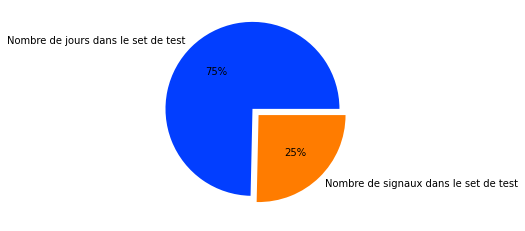

In [ ]:
#Diagrame signaux/jours
import seaborn as sns
colors = sns.color_palette('bright')[0:2]
explode = (0.1, 0.0)
plt.pie([periode_test,nombre_signaux],labels = ["Nombre de jours dans le set de test","Nombre de signaux dans le set de test"], colors = colors, autopct='%.0f%%',explode = explode)
#plt.legend()
plt.show()

In [ ]:
#Exemple : composition du portefeuille au premier signal
portf = pd.DataFrame(strat_1_res.iloc[0,:]['Portfolio'])
em_signaux = strat_1_res.iloc[0,:]['Emetteurs']

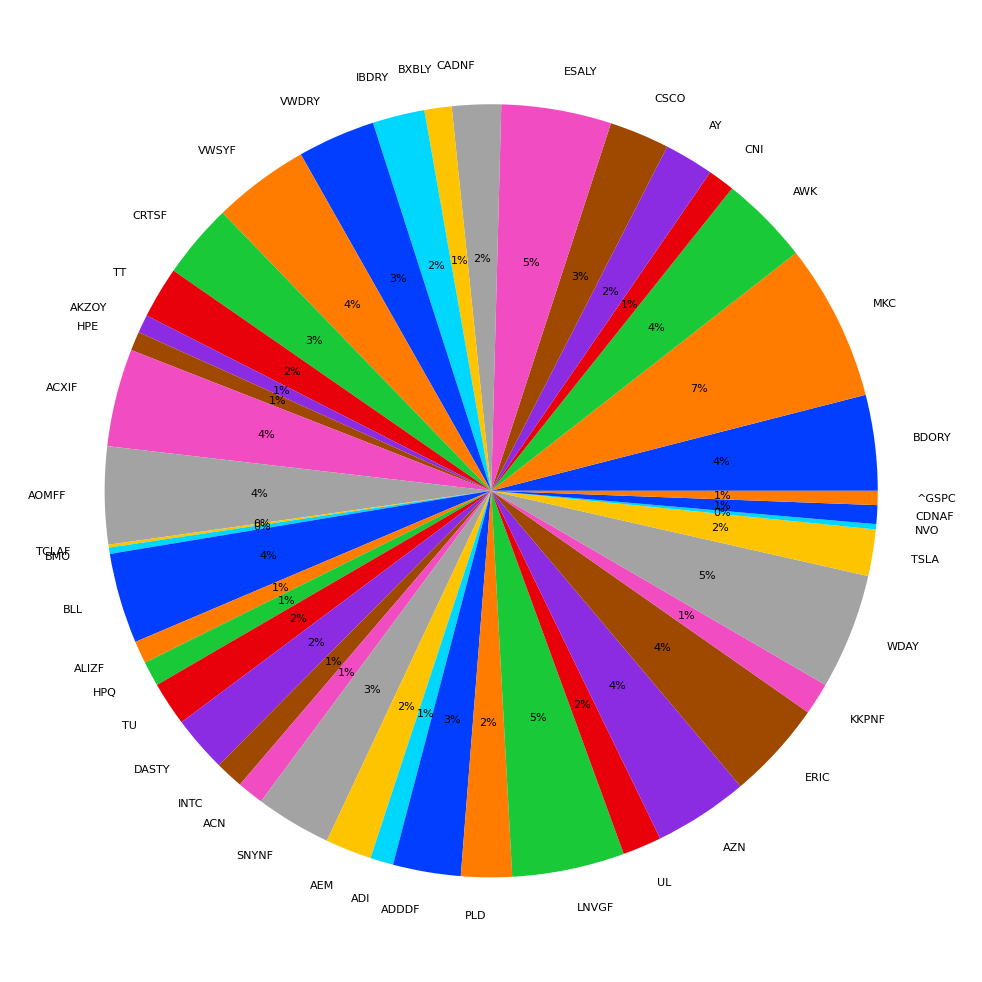

In [ ]:
import seaborn as sns
w = list(portf[portf.Poids>0].Poids)
stocks_names = list(portf[portf.Poids>0].Actif)
colors = sns.color_palette('bright')[0:len(portf)]
#explode = np.arange()
plt.figure(figsize=(25, 16), dpi=80)
plt.pie(w  ,labels = stocks_names , colors = colors, autopct='%.0f%%')
#plt.legend()
plt.show()

#

In [ ]:
em_signaux

array(['ADSK'], dtype=object)

In [ ]:
#Performance moyenne du portefeuille sur l'horizon de test : 
strat_1_res = pd.DataFrame(resultat)
strat_1_res = strat_1_res.drop_duplicates(subset = "Date",keep="last")
resultat_1 = {"Rendement":[], "Volatilité":[],	'Sharpe ratio':[]} 
resultat_1["Rendement"].append(strat_1_res.Rendement.mean())
resultat_1["Volatilité"].append(strat_1_res.Volatilité.mean())	
resultat_1["Sharpe ratio"].append(strat_1_res["Sharpe ratio"].mean() )
res_f = pd.DataFrame(resultat_1)
res_f[["Rendement","Volatilité"]] = res_f[["Rendement","Volatilité"]].applymap(lambda x: "{0:.1f}%".format(x*100))
res_f

,Rendement,Volatilité,Sharpe ratio
0,40.2%,15.9%,2.730559


#Strategie de test 2 :  Poids fixe <br/> <br/>
On calcule le poids sur l'échantillon de train et on garde les mêmes poids pour le back test sur l'échantillon de test

In [ ]:
#Etape 1 calculer les poids sur la périodes de train : 
poids_1 = calcule_portefeuille_optimal(train_rets)


#Etape 2 : calculer les rendements sur la période de test 
r_i = test_rets
w_i = (1/100) * poids_1[["Poids"]]

#volatility : calcul des rendement
var_p = w_i.values.reshape(-1,1)  *( r_i.cov() @ w_i.values.reshape(-1,1) ) * 252
var_p = var_p.sum()
std_p = np.sqrt(var_p)

#Returns 
r_p = r_i.mean().to_frame().T @  w_i.values.reshape(-1,1) * 252


#Sharpe
SR_p = (r_p - 0.0176)/std_p
portefeuille_2 = poids_1[poids_1.Poids>0.01].reset_index().drop('index',axis = 1)

resultat_2 = {"Portefeuille":[] , 'Rendement':[],'Volatilité':[],'Sharpe ratio':[] }
resultat_2["Portefeuille"].append( portefeuille_2.to_dict('records') )
resultat_2["Rendement"].append( r_p[0][0] )
resultat_2["Volatilité"].append( std_p[0] )
resultat_2["Sharpe ratio"].append( SR_p[0][0])

res_f2 = pd.DataFrame(resultat_2)
res_f2[["Rendement","Volatilité"]]  = res_f2[["Rendement","Volatilité"]] .applymap(lambda x: "{0:.1f}%".format(x*100))
res_f2

,Portefeuille,Rendement,Volatilité,Sharpe ratio
0,"[{'Actif': 'BDORY', 'Poids': 3.876326510738091...",23.0%,18.2%,1.167973


#Strategie de test 3 :  Poids dynamique <br/> <br/>
On réactualise le poids chaque 252 jours sur l'échantillon de test

In [ ]:
from datetime import timedelta
jours = 252
nbr_années_test = 3 #On décide de splitter sur 3 années
periode_annuelles = [test_rets.index[0] + timedelta(days=jours)] #Date à laquelle on attribue de nouveau poids
resultat_3 = {'Date':[] , "Portefeuille":[] , 'Rendement':[],'Volatilité':[],'Sharpe ratio':[] }
dates_intervalle = [ train_rets.index[-jours:] ] #dates des périodes de calcul des poids. 


#On récupère les périodes de calcul des poids et les dates auxquelles on attribue de nouveaux poids
for i in range(1,nbr_années_test+1) :
  periode_annuelles.append(  periode_annuelles[i-1] + timedelta(days=jours) )
  dates_intervalle.append(test_rets[ test_rets.index < periode_annuelles[i-1] ].index[-jours:] )


#Back test : 
for i in range(1,len(periode_annuelles) ) :
  data_poids =   returns[returns.index.isin(dates_intervalle[i-1]) ]  
  poids_2 = calcule_portefeuille_optimal(data_poids) #On calcule le poids sur les data dispo avant notre période de rotation
 
  #On calcule les rendements sur la période actuelle 
  r_i = returns[returns.index.isin(dates_intervalle[i]) ]  
  w_i = (1/100) * poids_2[["Poids"]]

  #volatility : calcule des rendement
  var_p = w_i.values.reshape(-1,1)  *( r_i.cov() @ w_i.values.reshape(-1,1) ) * 252
  var_p = var_p.sum()
  std_p = np.sqrt(var_p)

  #Returns 
  r_p = r_i.mean().to_frame().T @  w_i.values.reshape(-1,1) * 252


  #Sharpe
  SR_p = (r_p - 0.0176)/std_p
  portefeuille_3 = poids_2[poids_2.Poids>0.01].reset_index().drop('index',axis = 1)

  resultat_3["Date"].append( periode_annuelles[i] )
  resultat_3["Portefeuille"].append( portefeuille_3.to_dict('records') )
  resultat_3["Rendement"].append( r_p[0][0] )
  resultat_3["Volatilité"].append( std_p[0] )
  resultat_3["Sharpe ratio"].append( SR_p[0][0])


In [ ]:
strat_2_res = pd.DataFrame(resultat_3)
 

strat_2_res = pd.DataFrame(resultat_3)
strat_2_res[["Rendement","Volatilité"]]  = strat_2_res [["Rendement","Volatilité"]] .applymap(lambda x: "{0:.1f}%".format(x*100))
strat_2_res 

,Date,Portefeuille,Rendement,Volatilité,Sharpe ratio
0,2020-05-04,"[{'Actif': 'BDORY', 'Poids': 4.011902239658928...",15.3%,11.2%,1.209224
1,2021-01-11,"[{'Actif': 'STN', 'Poids': 0.6749539552876991}...",9.6%,23.8%,0.331628
2,2021-09-20,"[{'Actif': 'STN', 'Poids': 2.9979398655326484}...",52.6%,27.2%,1.868616


In [ ]:
#Resultat moyen des portefeuille sur la période de test.
strat_2_res = pd.DataFrame(resultat_3)
resultat_2 = {"Rendement":[], "Volatilité":[],	'Sharpe ratio':[]} 
resultat_2["Rendement"].append(strat_2_res.Rendement.mean())
resultat_2["Volatilité"].append(strat_2_res.Volatilité.mean())	
resultat_2["Sharpe ratio"].append(strat_2_res["Sharpe ratio"].mean() )
res_f3 = pd.DataFrame(resultat_2)
res_f3[["Rendement","Volatilité"]] = res_f3[["Rendement","Volatilité"]].applymap(lambda x: "{0:.1f}%".format(x*100))
res_f3

,Rendement,Volatilité,Sharpe ratio
0,25.9%,20.7%,1.136489
